In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
from string import *

In [97]:
# pbp = pd.read_csv('STLatVGK_21-10-20.csv')
pbp = pd.read_csv('NYIatPHI_21-09-28.csv')

In [4]:
cols = {'ANA':'#694632','ARI':'#7d1db3','BOS':'#ffec00','BUF':'#b653fb','CAR':'#963e3e','CBJ':'#475483','CGY':'#b45300','CHI':'#8d6b0a','COL':'#6b051f','DAL':'#007f16','DET':'#ff0000','EDM':'#55483d','FLA':'#77d200','L.A':'#1f1f1f','MIN':'#003a07','MTL':'#ec0365','N.J':'#ab0027','NSH':'#f3bf00','NYI':'#0078ff','NYR':'#07b182','OTT':'#646464','PHI':'#ff7c00','PIT':'#19bcd1','SEA':'#05f6db','S.J':'#016072','STL':'#000df0','T.B':'#150078','TOR':'#363caf','VAN':'#5c6c98','VGK':'#bca900','WPG':'#928d92','WSH':'#4d0069'}

In [5]:
def fo_parser(desc):
    
    winner, players = desc.split(' - ')
    zone = winner.split(' ')[2][:3]
    winner = winner[:3]
    player1, player2 = players.split(' vs ')
    team1 = player1[:3]
    team2 = player2[:3]
    
    if team1 == winner:
        winning_player = player1.split(' ')[-1]
        winning_team = team1
        losing_player = player2.split(' ')[-1]
        losing_team = team2
    elif team2 == winner:
        winning_player = player2.split(' ')[-1]
        winning_team = team2
        losing_player = player1.split(' ')[-1]
        losing_team = team1
        
    return zone, winning_player, winning_team, losing_player, losing_team

def advantager(cf, sf, fw, pd, g, t, s):
    
    return 0.1267380595068711*cf + 0.2797557173984735*sf + 0.08639459801588804*fw + 0.06876239334454985*pd + 0.08165454758042826*g + 0.09950296398800655*t + 0.25719172016578284*s

def percentager(a, b):
    if a + b == 0:
        c = 0.5
    else:
        c = a / (a + b)
    return c

def plusminuser(on_ice, plus_team, minus_team):
    
    for i in on_ice:
        if i in plus_team.keys():
            plus_team[i] += 1
        elif i in minus_team.keys():
            minus_team[i] -= 1
            
    return(plus_team, minus_team)

def plusminuser_weighted(on_ice, plus_team, minus_team, cf, sf, fw, pd, g, t, s):
    
    for i in on_ice:
        if i in plus_team.keys():
            plus_team[i] += 1 * advantager(cf, sf, fw, pd, g, t, s)
        elif i in minus_team.keys():
            minus_team[i] -= 1 * advantager(cf, sf, fw, pd, g, t, s)
            
    return(plus_team, minus_team)

In [6]:
def combo_pm(on_ice, players, cf, sf, fw, pd, g, t, s):
    
    if all(p in on_ice for p in players):
        return advantager(cf, sf, fw, pd, g, t, s)
    else:
        return 0

def combo_score(player_list, player_team):

    home_team = pbp['Home_Team'][0]
    away_team = pbp['Away_Team'][0]
    events = pbp['Event']
    descriptions = pbp['Description']
    
    if player_team == home_team:
        modifier = 1
    elif player_team == away_team:
        modifier = -1

    combo = 0
    n = 0

    for j, e in enumerate(events):

        n += 1

        on_ice = [pbp['awayPlayer1'][j], pbp['awayPlayer2'][j], pbp['awayPlayer3'][j], pbp['awayPlayer4'][j], pbp['awayPlayer5'][j], pbp['awayPlayer6'][j], pbp['homePlayer1'][j], pbp['homePlayer2'][j], pbp['homePlayer3'][j], pbp['homePlayer4'][j], pbp['homePlayer5'][j], pbp['homePlayer6'][j]]
            
        if e == 'SHOT':
            if descriptions[j].startswith(home_team):
                combo += combo_pm(on_ice, player_list, 1, 1, 0, 0, 0, 0, 0) * modifier
            elif descriptions[j].startswith(away_team):
                combo -= combo_pm(on_ice, player_list, 1, 1, 0, 0, 0, 0, 0) * modifier

        elif e == 'GOAL':
            if descriptions[j].startswith(home_team):
                combo += combo_pm(on_ice, player_list, 1, 1, 0, 0, 0, 0, 0) * modifier
            elif descriptions[j].startswith(away_team):
                combo -= combo_pm(on_ice, player_list, 1, 1, 0, 0, 0, 0, 0) * modifier

        elif e == 'BLOCK' or e == 'MISS':
            if descriptions[j].startswith(home_team):
                combo += combo_pm(on_ice, player_list, 1, 0, 0, 0, 0, 0, 0) * modifier
            elif descriptions[j].startswith(away_team):
                combo -= combo_pm(on_ice, player_list, 1, 0, 0, 0, 0, 0, 0) * modifier

        elif e == 'PENL':
            p_team = descriptions[j].split(' ')[0]
            mins = int(descriptions[j].split(' min)')[0].split('(')[-1])
            if p_team == home_team:
                combo -= combo_pm(on_ice, player_list, 0, 0, 0, 1, 0, 0, 0) * modifier
            elif p_team == away_team:
                combo += combo_pm(on_ice, player_list, 0, 0, 0, 1, 0, 0, 0) * modifier

        elif e == 'FAC':
            z, w, wt, l, lt = fo_parser(descriptions[j])
            if wt == home_team:
                combo += combo_pm(on_ice, player_list, 0, 0, 1, 0, 0, 0, 0) * modifier
            elif wt == away_team:
                combo -= combo_pm(on_ice, player_list, 0, 0, 1, 0, 0, 0, 0) * modifier

        elif e == 'GIVE':
            if descriptions[j].startswith(home_team):
                combo -= combo_pm(on_ice, player_list, 0, 0, 0, 0, 1, 0, 0) * modifier
            elif descriptions[j].startswith(away_team):
                combo += combo_pm(on_ice, player_list, 0, 0, 0, 0, 1, 0, 0) * modifier

        elif e == 'TAKE':
            if descriptions[j].startswith(home_team):
                combo += combo_pm(on_ice, player_list, 0, 0, 0, 0, 0, 1, 0) * modifier
            elif descriptions[j].startswith(away_team):
                combo -= combo_pm(on_ice, player_list, 0, 0, 0, 0, 0, 1, 0) * modifier
                                  
    return combo

In [128]:
# WEIGHTED VERSION

home_team = pbp['Home_Team'][0]
away_team = pbp['Away_Team'][0]
events = pbp['Event']
descriptions = pbp['Description']

home_unfiltered = [[a,b,c,d,e,f] for a,b,c,d,e,f in zip(pbp['homePlayer1'], pbp['homePlayer2'], pbp['homePlayer3'], pbp['homePlayer4'], pbp['homePlayer5'], pbp['homePlayer6'])]
home_weighted = np.unique(home_unfiltered)[:-1] # gets rid of nan values
score_placeholders = np.zeros(len(home_weighted))
home_weighted = dict(zip(home_weighted, score_placeholders))

away_unfiltered = [[a,b,c,d,e,f] for a,b,c,d,e,f in zip(pbp['awayPlayer1'], pbp['awayPlayer2'], pbp['awayPlayer3'], pbp['awayPlayer4'], pbp['awayPlayer5'], pbp['awayPlayer6'])]
away_weighted = np.unique(away_unfiltered)[:-1]
score_placeholders = np.zeros(len(away_weighted))
away_weighted = dict(zip(away_weighted, score_placeholders))

home_advantage = np.zeros(len(events))
away_advantage = np.zeros(len(events))
home_advantage_err = np.zeros(len(events))
away_advantage_err = np.zeros(len(events))
corsi_for_home = 0
corsi_for_away = 0
sog_for_home = 0
sog_for_away = 0
goals_for_home = 0
goals_for_away = 0
f_home = 0
f_away = 0
pmins_drawn_home = 0
pmins_drawn_away = 0
gives_against_home = 0
gives_against_away = 0
takes_for_home = 0
takes_for_away = 0

n = 0 # for SEM

for j, e in enumerate(events):
    
    n += 1

    on_ice = [pbp['awayPlayer1'][j], pbp['awayPlayer2'][j], pbp['awayPlayer3'][j], pbp['awayPlayer4'][j], pbp['awayPlayer5'][j], pbp['awayPlayer6'][j], pbp['homePlayer1'][j], pbp['homePlayer2'][j], pbp['homePlayer3'][j], pbp['homePlayer4'][j], pbp['homePlayer5'][j], pbp['homePlayer6'][j]]
    
    if e == 'SHOT':
        if descriptions[j].startswith(home_team):
            corsi_for_home += 1
            sog_for_home += 1
            plusminuser_weighted(on_ice, home_weighted, away_weighted, 1, 1, 0, 0, 0, 0, 0)
        elif descriptions[j].startswith(away_team):
            corsi_for_away += 1
            sog_for_away += 1
            plusminuser_weighted(on_ice, away_weighted, home_weighted, 1, 1, 0, 0, 0, 0, 0)

    elif e == 'GOAL':
        if descriptions[j].startswith(home_team):
            corsi_for_home += 1
            sog_for_home += 1
            goals_for_home += 1
            plusminuser_weighted(on_ice, home_weighted, away_weighted, 1, 1, 0, 0, 0, 0, 0)
        elif descriptions[j].startswith(away_team):
            corsi_for_away += 1
            sog_for_away += 1
            goals_for_away += 1
            plusminuser_weighted(on_ice, away_weighted, home_weighted, 1, 1, 0, 0, 0, 0, 0)

    elif e == 'BLOCK' or e == 'MISS':
        if descriptions[j].startswith(home_team):
            corsi_for_home += 1
            plusminuser_weighted(on_ice, home_weighted, away_weighted, 1, 0, 0, 0, 0, 0, 0)
        elif descriptions[j].startswith(away_team):
            corsi_for_away += 1
            plusminuser_weighted(on_ice, away_weighted, home_weighted, 1, 0, 0, 0, 0, 0, 0)

    elif e == 'PENL':
        p_team = descriptions[j].split(' ')[0]
        mins = int(descriptions[j].split(' min)')[0].split('(')[-1])
        if p_team == home_team:
            pmins_drawn_away += mins
            plusminuser_weighted(on_ice, away_weighted, home_weighted, 0, 0, 0, 1, 0, 0, 0)
        elif p_team == away_team:
            pmins_drawn_home += mins
            plusminuser_weighted(on_ice, home_weighted, away_weighted, 0, 0, 0, 1, 0, 0, 0)

    elif e == 'FAC':
        z, w, wt, l, lt = fo_parser(descriptions[j])
        if wt == home_team:
            f_home += 1
            plusminuser_weighted(on_ice, home_weighted, away_weighted, 0, 0, 1, 0, 0, 0, 0)
        elif wt == away_team:
            f_away += 1
            plusminuser_weighted(on_ice, away_weighted, home_weighted, 0, 0, 1, 0, 0, 0, 0)

    elif e == 'GIVE':
        if descriptions[j].startswith(home_team):
            gives_against_away += 1
            plusminuser_weighted(on_ice, away_weighted, home_weighted, 0, 0, 0, 0, 1, 0, 0)
        elif descriptions[j].startswith(away_team):
            gives_against_home += 1
            plusminuser_weighted(on_ice, home_weighted, away_weighted, 0, 0, 0, 0, 1, 0, 0)

    elif e == 'TAKE':
        if descriptions[j].startswith(home_team):
            takes_for_home += 1
            plusminuser_weighted(on_ice, home_weighted, away_weighted, 0, 0, 0, 0, 0, 1, 0)
        elif descriptions[j].startswith(away_team):
            takes_for_away += 1
            plusminuser_weighted(on_ice, away_weighted, home_weighted, 0, 0, 0, 0, 0, 1, 0)  
            
    cf_home = percentager(corsi_for_home, corsi_for_away)
    cf_away = percentager(corsi_for_away, corsi_for_home)
    sf_home = percentager(sog_for_home, sog_for_away)
    sf_away = percentager(sog_for_away, sog_for_home)
    gf_home = percentager(goals_for_home, goals_for_away)
    gf_away = percentager(goals_for_away, goals_for_home)
    fp_home = percentager(f_home, f_away)
    fp_away = percentager(f_away, f_home)
    pd_home = percentager(pmins_drawn_home, pmins_drawn_away)
    pd_away = percentager(pmins_drawn_away, pmins_drawn_home)
    ga_home = percentager(gives_against_home, gives_against_away)
    ga_away = percentager(gives_against_away, gives_against_home)
    tf_home = percentager(takes_for_home, takes_for_away)
    tf_away = percentager(takes_for_away, takes_for_home)
    saves_home = sog_for_away - goals_for_away
    saves_away = sog_for_home - goals_for_home
    sp_home = percentager(saves_home, saves_away)
    sp_away = percentager(saves_away, saves_home)
    
    home_advantage[j] = advantager(cf_home, sf_home, fp_home, pd_home, ga_home, tf_home, sp_home)
    away_advantage[j] = advantager(cf_away, sf_away, fp_away, pd_away, ga_away, tf_away, sp_away)
    
    home_advantage_err[j] = np.std((cf_home, sf_home, fp_home, pd_home, ga_home, tf_home, sp_home)) / np.sqrt(n)
    away_advantage_err[j] = np.std((cf_away, sf_away, fp_away, pd_away, ga_away, tf_away, sp_away)) / np.sqrt(n)

In [126]:
home_goalies = [goalie for goalie in list(set(pbp['Home_Goalie'])) if str(goalie) != 'nan']
away_goalies = [goalie for goalie in list(set(pbp['Away_Goalie'])) if str(goalie) != 'nan']

In [131]:
print(home_weighted)
for g in home_goalies:
    del home_weighted[g]
print(home_weighted)

{'CAM ATKINSON': 3.5392738629672538, 'CARTER HART': 1.7984852299119056, 'CLAUDE GIROUX': 1.046933191700277, 'CONNOR BUNNAMAN': -3.8951805371841433, 'DERICK BRASSARD': 4.267789940494651, 'EGOR ZAMULA': -4.692241029692098, 'GERMAN RUBTSOV': -1.9833217411222188, 'ISAAC RATCLIFFE': -0.38190719442488813, 'IVAN PROVOROV': -0.12667519306637665, 'JUSTIN BRAUN': 2.826091429973333, 'KEITH YANDLE': 3.4761412122829025, 'MAKSIM SUSHKO': -0.8154319825771857, 'MAXWELL WILLMAN': -1.1684110655789348, 'NICK SEELER': -4.414552594762018, 'OSKAR LINDBLOM': 1.2683603471315021, 'RYAN ELLIS': 2.449316965141816, 'SAMUEL ERSSON': -1.7285619510246555, 'SEAN COUTURIER': 1.1877472417777284, 'TRAVIS KONECNY': 1.4402557361930088, 'TYSON FOERSTER': 0.030815564548280716}
{'CAM ATKINSON': 3.5392738629672538, 'CLAUDE GIROUX': 1.046933191700277, 'CONNOR BUNNAMAN': -3.8951805371841433, 'DERICK BRASSARD': 4.267789940494651, 'EGOR ZAMULA': -4.692241029692098, 'GERMAN RUBTSOV': -1.9833217411222188, 'ISAAC RATCLIFFE': -0.3819

In [87]:
del home_weighted['ROBIN LEHNER']
home_sorted = {k: v for k, v in sorted(home_weighted.items(), key=lambda item: item[1], reverse=True)}
c = np.zeros((len(home_sorted), len(home_sorted)))
for i, k1 in enumerate(home_sorted.keys()):
    for j, k2 in enumerate(home_sorted.keys()):
        c[i, j] = combo_score([k1,k2], home_team)

In [89]:
del away_weighted['JORDAN BINNINGTON']
away_sorted = {k: v for k, v in sorted(away_weighted.items(), key=lambda item: item[1], reverse=True)}
c2 = np.zeros((len(away_sorted), len(away_sorted)))
for i, k1 in enumerate(away_sorted.keys()):
    for j, k2 in enumerate(away_sorted.keys()):
        c2[i, j] = combo_score([k1,k2], away_team)

In [79]:
home_cols = [cl.to_rgba(cols[away_team]), (1,1,1,1), cl.to_rgba(cols[home_team])]
home_map = cl.LinearSegmentedColormap.from_list('home map', home_cols, 300)
away_cols = [cl.to_rgba(cols[home_team]), (1,1,1,1), cl.to_rgba(cols[away_team])]
away_map = cl.LinearSegmentedColormap.from_list('away map', away_cols, 300)

<IPython.core.display.Javascript object>


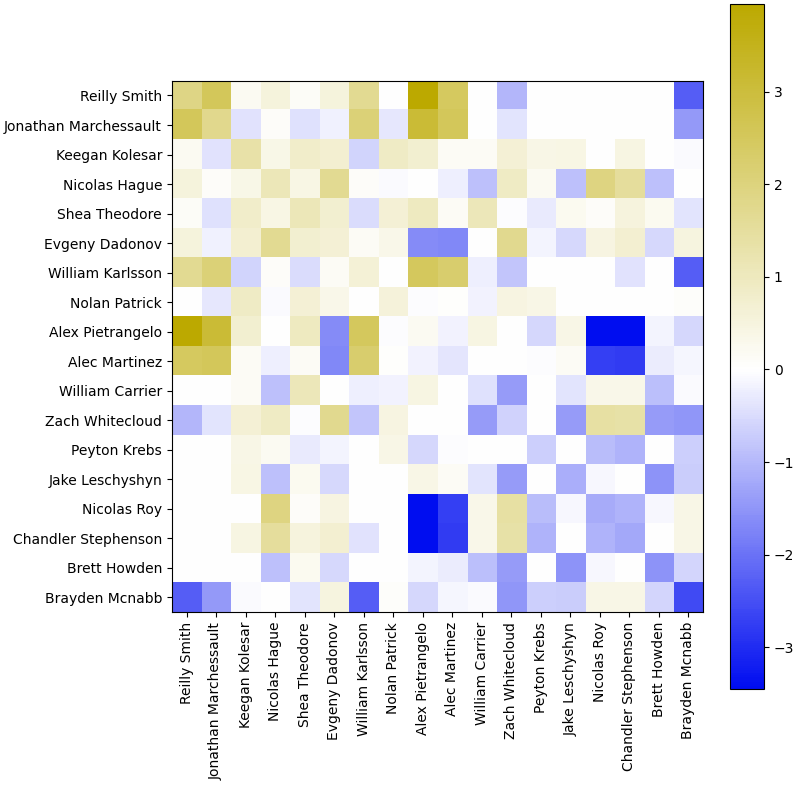

[Text(0, 0, 'Reilly Smith'),
 Text(0, 1, 'Jonathan Marchessault'),
 Text(0, 2, 'Keegan Kolesar'),
 Text(0, 3, 'Nicolas Hague'),
 Text(0, 4, 'Shea Theodore'),
 Text(0, 5, 'Evgeny Dadonov'),
 Text(0, 6, 'William Karlsson'),
 Text(0, 7, 'Nolan Patrick'),
 Text(0, 8, 'Alex Pietrangelo'),
 Text(0, 9, 'Alec Martinez'),
 Text(0, 10, 'William Carrier'),
 Text(0, 11, 'Zach Whitecloud'),
 Text(0, 12, 'Peyton Krebs'),
 Text(0, 13, 'Jake Leschyshyn'),
 Text(0, 14, 'Nicolas Roy'),
 Text(0, 15, 'Chandler Stephenson'),
 Text(0, 16, 'Brett Howden'),
 Text(0, 17, 'Brayden Mcnabb')]

In [88]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(8,8))

cmnorm = cl.TwoSlopeNorm(vcenter=0)
labels = [capwords(k) for k in home_sorted.keys()]

vibes = ax.imshow(c, cmap=home_map, norm=cmnorm)
plt.colorbar(vibes)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)

<IPython.core.display.Javascript object>


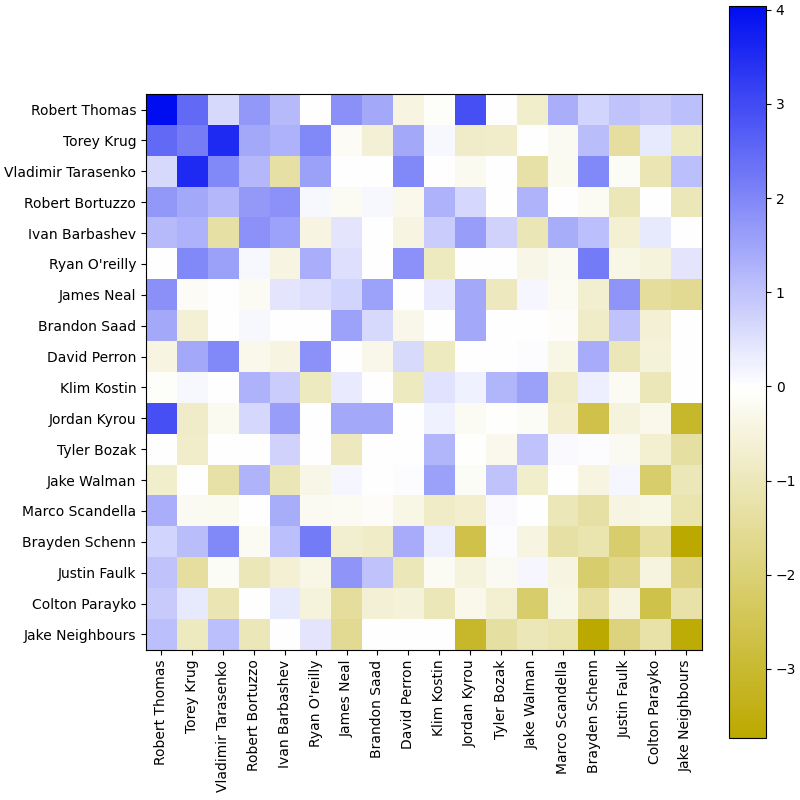

[Text(0, 0, 'Robert Thomas'),
 Text(0, 1, 'Torey Krug'),
 Text(0, 2, 'Vladimir Tarasenko'),
 Text(0, 3, 'Robert Bortuzzo'),
 Text(0, 4, 'Ivan Barbashev'),
 Text(0, 5, "Ryan O'reilly"),
 Text(0, 6, 'James Neal'),
 Text(0, 7, 'Brandon Saad'),
 Text(0, 8, 'David Perron'),
 Text(0, 9, 'Klim Kostin'),
 Text(0, 10, 'Jordan Kyrou'),
 Text(0, 11, 'Tyler Bozak'),
 Text(0, 12, 'Jake Walman'),
 Text(0, 13, 'Marco Scandella'),
 Text(0, 14, 'Brayden Schenn'),
 Text(0, 15, 'Justin Faulk'),
 Text(0, 16, 'Colton Parayko'),
 Text(0, 17, 'Jake Neighbours')]

In [90]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(8,8))

cmnorm = cl.TwoSlopeNorm(vcenter=0)
labels = [capwords(k) for k in away_sorted.keys()]

vibes = ax.imshow(c2, cmap=away_map, norm=cmnorm)
plt.colorbar(vibes)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)